# Setup

In [1]:
%%capture
!pip3 install transformers
!pip3 install torchtext
!python3 -m spacy download en_core_web_md
!python3 -m spacy download en

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
from numpy import asarray as array
import spacy
from transformers import BertTokenizer

In [4]:
nlp = spacy.load('en_core_web_md') #48 MB

In [5]:
DATA = Path('/home/sharif/Documents/real-or-not/data')
train, test = pd.read_csv(DATA/'train.csv'), pd.read_csv(DATA/'test.csv')

# EDA

TODO: 1 percentage vs 0 percentage?

In [6]:
len(train), len(test)

(7613, 3263)

## Train Data

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Target

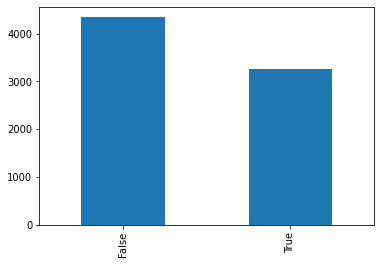

In [8]:
(train.target == 1).value_counts().plot.bar();

### Text

Interesting features:
- All caps
- Links (YouTube)
- !?

In [9]:
for i in range(10): train.text.loc[i]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

'Forest fire near La Ronge Sask. Canada'

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

'13,000 people receive #wildfires evacuation orders in California '

'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

'#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'

"I'm on top of the hill and I can see a fire in the woods..."

"There's an emergency evacuation happening now in the building across the street"

"I'm afraid that the tornado is coming to our area..."

### Keywoard

%20 stands for space.

In [10]:
train.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
harm                     41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [11]:
train.keyword.isna().sum()

61

### Location

In [12]:
train.location.value_counts()

USA                          104
New York                      71
United States                 50
London                        45
Canada                        29
                            ... 
The P (South Philly)           1
PS4, now stop asking           1
Minority Privilege, USA        1
3?3?7?SLOPelousas??2?2?5?      1
Worcester, MA                  1
Name: location, Length: 3341, dtype: int64

In [13]:
train.location.isna().sum()

2533

## Test Data

In [14]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Helpers

In [15]:
def random_idx(): return np.random.randint(0, len(train))
def random_txt(): return train.text.sample().item()
def txt_by_idx(idx): return train.loc[train.id == idx].text.item()

# NLP

TODO: Look at mean, std of word embedding vectors.

https://spacy.io/usage/vectors-similarity

In [16]:
sentence = random_txt(); sentence

'Enugu Government to demolish illegal structures at International Conference Centre http://t.co/DaqszZuBUb'

## Word2Vec

#### If the word is not recognizable by spacy the word embedding contains only 0. These can be removed.

In [17]:
doc = nlp(sentence)
assert len(doc[0].vector) == 300

for token in doc: 
    if not np.any(token.vector): str(token)

'Enugu'

'http://t.co/DaqszZuBUb'

In [18]:
def is_all_zeros(x): return not np.any(x)

assert is_all_zeros(np.array([1,0,0])) == False
assert is_all_zeros(np.array([0,0,0])) == True

In [19]:
def vectorize(sentence):
    doc = nlp(sentence)
    return array([token.vector for token in doc if not is_all_zeros(token.vector)])

## Tokenization

### Spacy

In [20]:
doc = nlp(sentence)
[token.text for token in doc]

['Enugu',
 'Government',
 'to',
 'demolish',
 'illegal',
 'structures',
 'at',
 'International',
 'Conference',
 'Centre',
 'http://t.co/DaqszZuBUb']

### Gensim

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased');

In [22]:
tokenizer.tokenize(sentence)

['en',
 '##ug',
 '##u',
 'government',
 'to',
 'demo',
 '##lish',
 'illegal',
 'structures',
 'at',
 'international',
 'conference',
 'centre',
 'http',
 ':',
 '/',
 '/',
 't',
 '.',
 'co',
 '/',
 'da',
 '##q',
 '##sz',
 '##zu',
 '##bu',
 '##b']

# Model

TODO: Batching (padding?)

In [70]:
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext import data
import torch.optim as optim

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Model

In [79]:
IN = 300
N_HIDDEN = 300
N_LAYERS = 2
OUT = 1

In [81]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(IN, N_HIDDEN, N_LAYERS)
        self.fc   = nn.Linear(N_HIDDEN, OUT)
    def forward(self, x):
        y, (hidden, cell) = self.lstm(x)
        y                 = self.fc(hidden[-1,None,-1])
        return y

### Dataset

In [82]:
class TextDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        row = self.data.loc[idx]
        x = tensor(vectorize(row.text))
        y = tensor([row.target]).float()
        return x.to(device), y.to(device), row.text

In [27]:
ds = TextDataset(train)
x,y,txt = ds[random_idx()]

In [28]:
assert type(x) == torch.Tensor
assert type(y) == torch.Tensor
assert x.dtype == torch.float32
assert y.dtype == torch.float32
assert x.shape[1] == 300

### Train/Test split

In [29]:
p = 0.7

In [30]:
msk = np.random.rand(len(train)) < p

In [31]:
train_data = train[msk]
valid_data = train[~msk]

len(train_data), len(valid_data)

(5325, 2288)

In [32]:
train_data.reset_index(inplace=True)
valid_data.reset_index(inplace=True)

In [33]:
train_ds = TextDataset(train_data)
valid_ds = TextDataset(valid_data)

In [34]:
len(train_ds), len(valid_ds)

(5325, 2288)

### Dataloader

In [83]:
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

In [84]:
len(train_dl), len(val_dl)

(5325, 2288)

In [85]:
for x,y,_ in train_dl:
    print(y)
    print(x.shape)
    break

tensor([[1.]], device='cuda:0')
torch.Size([1, 10, 300])


### Train

In [86]:
m = LSTM()
m.to(device);
m.train();

In [87]:
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(m.parameters())

In [88]:
def accuracy(y, y_hat): return ((y_hat > 0.5) == bool(y)).item()

In [ ]:
for e in range(100):
    losses,accs = [],[]
    for i, (x,y,_) in enumerate(train_dl):
        if i % 1000 == 0: print(i, '/', len(train_dl))
        try: y_hat = m(x)
        except: continue
        l = criterion(y_hat, y)
        accs.append(accuracy(y, y_hat))
        opt.zero_grad()
        l.backward()
        opt.step()
        losses.append(l.item())
    print(round(sum(losses)/len(losses), 2))
    print(sum(accs)/len(accs))

0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.65
0.6096919609316304
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.62
0.6523290758827949
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.59
0.6684823441021788
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.56
0.6855747558226897
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.54
0.6898948159278738
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.52
0.7064237415477085
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.51
0.7096168294515401
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.5
0.7128099173553719
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.49
0.7212622088655146
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.49
0.7216378662659655
0 / 5325
1000 / 5325
2000 / 5325
3000 / 5325
4000 / 5325
5000 / 5325
0.

In [ ]:
# 1 layer: train: 61, 63, 64, 65, 65
# 2 layer: 60, 65, 66, 68, 68, 70, 71, 72
# no train: 57, 57